In [1]:
!pip install pretty_midi
!pip install Instrument
!pip install mido


     |████████████████████████████████| 5.6MB 6.7MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=605b21142ef831b685c8b10c853030f8207c1dac18ee467f0842eda87f6765af
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi
     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for Instrument: filename=instrument-0.6.0-cp36-none-any.whl size=10993 sha256=d08b2fe88e99e9ae5c0184472f91da3810c4fcfb5f48b5b8d5f410c102fa1e68
  Stored in directory: /root/.cache/pip/wheels/3d/37/67/e371f926934582de6a6ff27130d4d17610661f35c7ed61ab2b
Successfully built Instrument


In [2]:
from pretty_midi.constants import DRUM_MAP, INSTRUMENT_MAP, INSTRUMENT_CLASSES
import numpy as np
import re
from pretty_midi.utilities import key_number_to_key_name
from pretty_midi.containers import PitchBend
from pretty_midi.instrument import Instrument
import os
import pretty_midi
from scipy.io import wavfile 
import IPython
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn

In [4]:
# Change this part to locate the correct directory where dataset resides
use_colab = True

if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    DATA_DIRECTORY = "/content/gdrive/My Drive/data"
    
    

Mounted at /content/gdrive


In [6]:
n_x = 108
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

import os
from os import listdir
from os.path import isfile, join

# Modify this path to your own MAESTRO dataset
maestro_dir = '/content/gdrive/My Drive/data/maestro-v2.0.0'

data_dirs1 = []
data_dirs2 = []

for year in ['2004', '2008', '2009', '2011', '2013', '2014', '2015', '2017', '2018']:
#for year in ['2004']:
    data_dirs1.append(maestro_dir + '/' + str(year))
for year in ['2006']:
    data_dirs2.append(maestro_dir + '/' + str(year))

data_files1 = []
data_files2 = []
for data_dir in data_dirs1:
    data_files1 += [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if 'midi' in f]
for data_dir in data_dirs2:
    data_files2 += [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if 'midi' in f]

data_files1.sort()
data_files2.sort()

print('total midi files : ', len(data_files2))
print('total midi files : ', len(data_files1))

total midi files :  115
total midi files :  1167


In [8]:
max = 0
train_list = []
test_list = []

for midiFile in data_files1:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    for note in note_l:
        train_list.append(note)
    if (np.max(note_l) >= max):
      max = np.max(note_l)
for midiFile in data_files2:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    if (np.max(note_l) >= max):
      max = np.max(note_l)
    for note in note_l:
        test_list.append(note)
n_x = max
print(n_x)
print(len(train_list))
print(len(test_list))

108
6261870
864448


In [9]:
data_train = np.asarray(train_list)
data_train = data_train - np.min(data_train)
data_train = torch.from_numpy(data_train)
data_test = np.asarray(test_list)
data_test = data_test - np.min(data_test)
data_test = torch.from_numpy(data_test)
print("train_size",data_train.size())
print("test_size",data_test.size())

train_size torch.Size([6261870])
test_size torch.Size([864448])


In [31]:
def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data

batch_size = 256
eval_batch_size = 128
train_data = batchify(data_train, batch_size)
test_data = batchify(data_test, eval_batch_size)

In [32]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F
class MultiHeadSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    You can also use torch.nn.MultiheadAttention to validate your implementation

    """
    def __init__(self, n_embd, n_head, block_size, attn_pdrop=0.1, resid_pdrop=0.1):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        #Define key, query, value projections for all heads
        """YOUR CODE HERE"""
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        # Dropout layers
        self.attn_drop = nn.Dropout(attn_pdrop)
        self.resid_drop = nn.Dropout(resid_pdrop)
        # output projection
        self.proj = nn.Linear(n_embd, n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        #mask = (torch.triu(torch.ones(block_size, block_size)) == 1).view(1, 1, block_size, block_size)
        #self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size))
        #                          .view(1, 1, block_size, block_size))
        self.mask = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)

        

    def forward(self, x, layer_past=None):
        B, T, C = x.size() # B = Batch
        """YOUR CODE HERE"""
        s = C // self.n_head
        k = self.key(x).view(B,T,self.n_head, s)
        q = self.query(x).view(B,T,self.n_head, s)
        v = self.value(x).view(B,T,self.n_head, s)
        
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(s)
        mask = self.mask
        scores = scores.float().masked_fill(mask[:,:,:T,:T] == 0, float('-inf'))
        scores = F.softmax(scores, dim=-1)
        scores = self.attn_drop(scores)
        scores = torch.matmul(scores, v)
        
        concat = scores.transpose(1,2).contiguous().view(B, T, C)
        
        output = self.proj(concat)
        output = self.resid_drop(output)
        return output
      

In [33]:
class TransformerBlock(nn.Module):
    """ an Transformer block """

    def __init__(self, n_embd, n_head, block_size, attn_pdrop=0.1, resid_pdrop=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadSelfAttention(n_embd, n_head, block_size, attn_pdrop, resid_pdrop)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(resid_pdrop),
        )

    def forward(self, x):
        """YOUR CODE HERE?""" 
        x1 = self.ln1(x)
        x2 = x + self.attn(x1) 
        x3 = self.ln2(x2)
        out = x2 + self.mlp(x3)
      # please read the note below!
        return out


In [34]:
class GPT(nn.Module):
    """  the full GPT language model, with a squence size of block_size """

    def __init__(self, vocab_size, n_embd, n_head, block_size, n_layer, embd_pdrop=0.1, attn_pdrop=0.1,resid_pdrop=0.1):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.drop = nn.Dropout(embd_pdrop)
        # transformer
        """YOUR CODE HERE"""
        self.blocks = n_layer
        tblocks = []
        for i in range(self.blocks):
            tblocks.append(
                TransformerBlock(n_embd, n_head, block_size, attn_pdrop, resid_pdrop))
        self.tblocks = nn.Sequential(*tblocks)
        
        # decoder head
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

        self.block_size = block_size
        self.apply(self._init_weights)

        #logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        You don't need to change this function. This is setting specific parameters for optimization.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, x, targets=None):
        b, t = x.size()
        #print("block size:", self.block_size)
        #print("t: ", t)
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        """YOUR CODE HERE"""
        tokens = self.tok_emb(x)
        pos = self.pos_emb[:, :t, :]
        x = tokens + pos
        x = self.drop(x)
        x = self.tblocks(x)
        x = self.ln_f(x)

        # forward the GPT model
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [35]:
import math
import logging
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

In [36]:
bptt = 100
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target
ntokens = n_x # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 8 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = GPT(vocab_size = ntokens+1, n_embd=emsize, n_head=nhead, block_size = 256, n_layer=nlayers)

In [ ]:
criterion = nn.CrossEntropyLoss()
#lr = 5.0 # learning rate
optimizer = torch.optim.AdamW(model.parameters())
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 5000)
import time
device = 'cpu'
if torch.cuda.is_available():
  device = torch.cuda.current_device()
  model = torch.nn.DataParallel(model).to(device)

tokens = 0
acc = []
for epoch in range(50):
    start_time = time.time()
    model.train()
    losses = []
    total_loss = 0
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        # place data on the correct device
        data, targets = get_batch(train_data, i)
        data = data.to(device)
        targets = targets.to(device)
        # forward the model
        optimizer.zero_grad()
        logits, loss = model(data,targets)
        count = 0
        index = 0
        for i in range(logits.shape[0]):
          for j in range(logits.shape[1]):
            if(abs(targets[index]-torch.argmax(logits[i,j,:])) <= 7):
              count +=1
            index += 1
        acc.append(count/targets.shape[0])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        losses.append(loss.item())
        total_loss += loss.item()
        log_interval = 5
        if batch % log_interval == 0 and batch >= 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches |'
                  '| ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt,
                    elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [ ]:
tokens = 0
test_acc = []
for epoch in range(5):
    start_time = time.time()
    model.train()
    for batch, i in enumerate(range(0, test_data.size(0) - 1, bptt)):
        # place data on the correct device
        data, targets = get_batch(test_data, i)
        logits, loss = model(data,targets)
        count = 0
        index = 0
        for i in range(logits.shape[0]):
          for j in range(logits.shape[1]):
            if(abs(targets[index]-torch.argmax(logits[i,j,:])) <= 7):
              count +=1
            index += 1
        test_acc.append(count/targets.shape[0])
        log_interval = 10
        if batch % log_interval == 0 and batch >= 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            print("current accuracy", count/targets.shape[0])
            total_loss = 0
            start_time = time.time()
        scheduler.step()


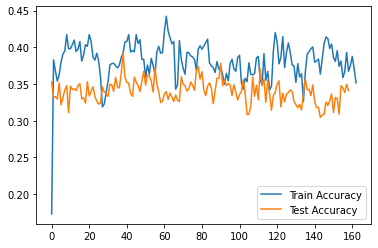

In [ ]:
plt.plot(acc)
plt.plot(test_acc)
plt.legend(('Train Accuracy', 'Test Accuracy'),
             loc='lower right')

In [ ]:
data, targets = get_batch(train_data, 20)

In [ ]:
logits, loss = model(data,targets)
print(logits)

tensor([[[ -9.0919,  -8.8899,  -9.1337,  ...,  -8.7711,  -8.9354,  -8.5692],
         [ -9.6467,  -9.6245,  -9.9092,  ...,  -9.3555,  -9.0722,  -9.3535],
         [ -7.7888,  -7.6135,  -8.1444,  ...,  -7.4387,  -7.8775,  -7.2536],
         ...,
         [ -7.1113,  -6.8453,  -7.4260,  ...,  -6.1231,  -7.2359,  -7.1234],
         [ -7.6613,  -7.3039,  -7.8746,  ...,  -7.6941,  -7.7106,  -7.4072],
         [ -6.9505,  -6.9825,  -7.2941,  ...,  -6.7114,  -6.8657,  -6.8256]],

        [[ -9.4573,  -9.5876,  -9.8754,  ...,  -9.3808,  -9.0609,  -9.3327],
         [ -9.3021,  -9.3640,  -9.4557,  ...,  -8.8656,  -8.6551,  -8.9596],
         [ -7.0162,  -6.8743,  -7.4016,  ...,  -6.3870,  -6.4116,  -6.1724],
         ...,
         [ -6.3331,  -6.6431,  -6.6146,  ...,  -6.1309,  -6.0364,  -6.2350],
         [ -8.1949,  -8.3349,  -8.6549,  ...,  -7.9620,  -8.2086,  -8.2693],
         [ -7.8492,  -7.9735,  -8.1900,  ...,  -8.0545,  -7.6371,  -7.6174]],

        [[ -9.5274,  -9.3663,  -9.7098,  ...

In [ ]:
note = []
for i in range(logits.shape[0]):
    for j in range(logits.shape[1]):
        note.append(torch.argmax(logits[i,j,:]))
print(note)

[tensor(72), tensor(76), tensor(79), tensor(79), tensor(84), tensor(72), tensor(82), tensor(38), tensor(101), tensor(62), tensor(63), tensor(82), tensor(48), tensor(79), tensor(58), tensor(79), tensor(76), tensor(76), tensor(79), tensor(81), tensor(75), tensor(56), tensor(72), tensor(44), tensor(63), tensor(62), tensor(87), tensor(81), tensor(67), tensor(75), tensor(37), tensor(53), tensor(51), tensor(70), tensor(60), tensor(62), tensor(71), tensor(51), tensor(56), tensor(63), tensor(76), tensor(67), tensor(82), tensor(47), tensor(75), tensor(74), tensor(79), tensor(72), tensor(58), tensor(68), tensor(67), tensor(58), tensor(70), tensor(66), tensor(67), tensor(61), tensor(76), tensor(68), tensor(36), tensor(44), tensor(70), tensor(46), tensor(44), tensor(60), tensor(74), tensor(74), tensor(73), tensor(43), tensor(49), tensor(79), tensor(74), tensor(54), tensor(94), tensor(65), tensor(61), tensor(70), tensor(64), tensor(63), tensor(58), tensor(73), tensor(64), tensor(67), tensor(79), te

In [ ]:
note = np.asarray(note)
new_midi_data = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)
time = 0
step = 0.2
for note_number in note:
    myNote = pretty_midi.Note(velocity=120, pitch=note_number, start=time, end=time+step)
    piano.notes.append(myNote)
    time += step
new_midi_data.instruments.append(piano)